# Utils functions

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import interpolate
from pykalman import KalmanFilter


#Define useful functions
def Kalman1D(observations,damping=0):
    # To return the smoothed time series data
    observation_covariance = damping
    initial_value_guess = observations[0]
    transition_matrix = 1
    transition_covariance = 0.1
    initial_value_guess
    kf = KalmanFilter(
            initial_state_mean=initial_value_guess,
            initial_state_covariance=observation_covariance,
            observation_covariance=observation_covariance,
            transition_covariance=transition_covariance,
            transition_matrices=transition_matrix
        )
    pred_state, state_cov = kf.smooth(observations)
    return pred_state


def LCIS(arr):
    decrease_cnt = 0
    start_index = 0
    end_index = 0
    sub_len = 0
    longest_start = 0
    longest_end = 0
    longest_len = 0
    decrease_point_0 = -1
    decrease_point_1 = -1
    for i in range(1, len(arr)):
        if arr[i] > arr[i-1]:
            end_index += 1
        else:
            decrease_cnt += 1
            if decrease_cnt == 1:
                end_index += 1
                decrease_point_0 = end_index

            elif decrease_cnt == 2:
                end_index += 1
                decrease_point_1 = end_index
                
            else:
                sub_len = end_index - start_index + 1
                if longest_len < sub_len:
                    longest_len = sub_len
                    longest_start = start_index
                    longest_end = end_index
                start_index = decrease_point_0
                decrease_point_0 = decrease_point_1
                decrease_point_1 = i
                end_index = i
                decrease_cnt = 2

    sub_len = end_index - start_index + 1
    if longest_len < sub_len:
        longest_len = sub_len
        longest_start = start_index
        longest_end = end_index


    start = longest_start
    end = longest_end
    longest_start = 42
    longest_end = 98
    return longest_start, longest_end+1,arr[longest_start:longest_end+1],start,end+1

    # print('start index: {}, end index: {}, len: {}, LCIS: {}'.format(longest_start, longest_end, longest_len, arr[longest_start:longest_end+1]))
#     mm = np.arange(longest_start, longest_end, 1)
#     c_max = max(arr)
#     c_min = min(arr)
#     hope_start = 42
#     hope_end=98
#     for i in range(hope_start,hope_end+1):
#         if i not in mm:
#             temp = (arr[i]-c_min)/(c_max-c_min)*c_max
#             arr[i] = temp

# Calulating usability

In [99]:
def get_usability(file_name):
    # './hardware_data/I-V_data_0.7um_length_200nm_diameter_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_carbon_paste.xlsx'
    df = pd.read_excel(file_name, engine='openpyxl')

    #data cleaning
    dropcolumn = []
    for i in range(len(df.columns)):
        if 'Unnamed' in df.columns[i]:
            dropcolumn.append(df.columns[i])

    df = df.drop(columns=dropcolumn)
    df = df.dropna(axis=0, how='all')

    #calculate mean and std current for each row and remove the NAN
    voltage = df['voltage']
    current_mean_list = []
    current_std_list = []
    for i in range(len(voltage)):
        # print(1)
        current_row = df.iloc[[i]].to_numpy()
        try:
            current_row = current_row[~np.isnan(current_row)]
        except:
            pass

        low_percentile = np.percentile(current_row, 25)
        high_percentile = np.percentile(current_row, 75)
        current_row = current_row[(current_row >=low_percentile ) & (current_row <= high_percentile)]

        current_mean = np.mean(current_row)

        current_std = np.std(current_row)
        current_mean_list.append(current_mean)
        current_std_list.append(current_std)

    current_mean_list = np.array(current_mean_list)
    current_std_list = np.array(current_std_list)

    voltage_list = df['voltage'].to_numpy()

    conductance_mean = current_mean_list/(voltage_list+1e-9)
    conductance_std = current_std_list/(voltage_list+1e-9)

    c_mean_smooth = conductance_mean[1:100]
    c_std_smooth = conductance_std[1:100]


    c_mean_smooth = Kalman1D(c_mean_smooth,damping=1)
    c_std_smooth = Kalman1D(c_std_smooth,damping=1)


    longest_start, longest_end, arr, start, end = LCIS(c_mean_smooth)

    usability = (longest_end-longest_start)/100.*(1-sum(c_std_smooth)/sum(c_mean_smooth))
    return usability

# get_usability('./hardware_data/I-V_data_0.7um_length_200nm_diameter_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_carbon_paste.xlsx')
get_usability('./hardware_data/I-V_data_2.5um_length_200nm_diameter_NA_third_etch_25min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_8V_silver_paste.xlsx')

ValueError: not enough values to unpack (expected 5, got 2)

In [3]:
# print("xxxxxxxxxxxxxxxxxxxxxxxxxx")
# print(usability)

# #Curve interpolations
# x = np.arange(longest_start, longest_end, 1)
# y = arr 
# interp_func_mean = interpolate.splrep(x, y, s=0)


# y_std = c_std_smooth[longest_start:longest_end]
# interp_func_std = interpolate.splrep(x, y_std, s=0)



# xfit = np.linspace(longest_start, longest_end, 100)
# yfit = interpolate.splev(xfit, interp_func_mean, der=0)
# yfit_std = interpolate.splev(xfit, interp_func_std, der=0) #计算取样点的插值结果




# y_p = []
# for i in range(len(yfit)):
#     y_p.append(1)
# mm = np.arange(start, end, 1)
# c_max = max(yfit)
# c_min = min(yfit)
# hope_start = 42
# hope_end=98
# for i in range(hope_start,hope_end+1):
#     if i not in mm:
#         temp = (yfit[i]-c_min)/(c_max-c_min)
#         y_p[i] = temp

# df_from_arr = pd.DataFrame({'SweepingTime':xfit,'Conductance_mean':yfit, 'Conductance_std':yfit_std, 
#                             'Conductance_std_ratio': yfit_std/(yfit+1e-9),'radio':y_p})


# df_from_arr.to_csv('0.14_ratio_hw_conductance_std.csv', index=False)

# file2usability

In [4]:
import pandas as pd
import os

dir_name = 'hardware_data/'#'./data_refined/'  # 

hw_data_files = os.listdir(dir_name)
# len(hw_data_files) # 38

file2usability = {}
for f_name in sorted(hw_data_files):
    if f_name.endswith('xlsx'):
        print(f_name)

        try:
            print(get_usability(dir_name+f_name)[0])
            file2usability[f_name] = get_usability(dir_name+f_name)[0]
        except:
            print('!!!!!!!!')
            file2usability[f_name] = None
        # df = pd.read_excel('hardware_data/'+f_name, engine='openpyxl')
        # print(df.shape)
    

I-V_data_0.7um_length_200nm_diameter_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_carbon_paste.xlsx
0.2641632692293397
I-V_data_0.7um_length_200nm_diameter_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_probe.xlsx
0.5346664824133427
I-V_data_0.7um_length_200nm_diameter_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_silver_paste.xlsx
0.4476151015635515
I-V_data_0.7um_length_200nm_diameter_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_5V_silver_paste.xlsx
0.4087611447459245
I-V_data_0.7um_length_200nm_diameter_NA_third_etch_25min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_8V_carbon_paste.xlsx
0.41103895850549743
I-V_data_1.2um_length_200nm_diameter_NA_third_etch_15min_Pb_ED_10h_180+210C_FAI_PMMA_200nm_Ag_memory_6V_probe.xlsx
0.4820345513335516
I-V_data_1.2um_length_200nm_diameter_NA_third_etch_15min_Pb_ED_10h_180+210C_FAI_PMMA_200nm_Ag_memory_6V_silver_paste.xlsx
0.5047464961368245
I-V_data_1.2um_length_200nm_diameter_NA_third_etch_15min_Pb_E

In [5]:
file2usability

{'I-V_data_0.7um_length_200nm_diameter_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_carbon_paste.xlsx': 0.2641632692293397,
 'I-V_data_0.7um_length_200nm_diameter_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_probe.xlsx': 0.5346664824133427,
 'I-V_data_0.7um_length_200nm_diameter_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_silver_paste.xlsx': 0.4476151015635515,
 'I-V_data_0.7um_length_200nm_diameter_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_5V_silver_paste.xlsx': 0.4087611447459245,
 'I-V_data_0.7um_length_200nm_diameter_NA_third_etch_25min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_8V_carbon_paste.xlsx': 0.41103895850549743,
 'I-V_data_1.2um_length_200nm_diameter_NA_third_etch_15min_Pb_ED_10h_180+210C_FAI_PMMA_200nm_Ag_memory_6V_probe.xlsx': 0.4820345513335516,
 'I-V_data_1.2um_length_200nm_diameter_NA_third_etch_15min_Pb_ED_10h_180+210C_FAI_PMMA_200nm_Ag_memory_6V_silver_paste.xlsx': 0.5047464961368245,
 'I-V_data_1.2um_length_20

# Save file2usability

In [6]:
import numpy as np

my_dict = file2usability  # { 'Apple': 4, 'Banana': 2, 'Orange': 6, 'Grapes': 11}
# 保存文件
np.save('file2usability.npy', my_dict)
# 读取文件 
new_dict = np.load('file2usability.npy', allow_pickle='TRUE').item()
print(new_dict)


{'I-V_data_0.7um_length_200nm_diameter_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_carbon_paste.xlsx': 0.2641632692293397, 'I-V_data_0.7um_length_200nm_diameter_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_probe.xlsx': 0.5346664824133427, 'I-V_data_0.7um_length_200nm_diameter_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_silver_paste.xlsx': 0.4476151015635515, 'I-V_data_0.7um_length_200nm_diameter_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_5V_silver_paste.xlsx': 0.4087611447459245, 'I-V_data_0.7um_length_200nm_diameter_NA_third_etch_25min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_8V_carbon_paste.xlsx': 0.41103895850549743, 'I-V_data_1.2um_length_200nm_diameter_NA_third_etch_15min_Pb_ED_10h_180+210C_FAI_PMMA_200nm_Ag_memory_6V_probe.xlsx': 0.4820345513335516, 'I-V_data_1.2um_length_200nm_diameter_NA_third_etch_15min_Pb_ED_10h_180+210C_FAI_PMMA_200nm_Ag_memory_6V_silver_paste.xlsx': 0.5047464961368245, 'I-V_data_1.2um_length_200nm_dia

In [7]:
def calculate(file):
    # df = pd.read_excel(file)
    # df = pd.read_excel('I-V_data_25min_AAO_10min_Pb_ED_1h_180C_MAI_memory_8V_2.xlsx') #0.55
    # df = pd.read_excel('I-V_data_30min_AAO_5min second etch_15min_Pb_ED_3h_180C_MAI_200nm_Ag_memory_6V.xlsx') #0.33
    df = pd.read_excel(file, engine='openpyxl') #0.14
    # sunqiao/OpenPCDet/tools/hardware_noise/hardware_data/I-V_data_0.7um_length_200nm_diameter_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_carbon_paste.xlsx
    dropcolumn = []
    for i in range(len(df.columns)):
        if 'Unnamed' in df.columns[i]:
            dropcolumn.append(df.columns[i])
            

    df = df.drop(columns=dropcolumn)
    df = df.dropna(axis=0, how='all')

    #calculate mean and std current for each row and remove the NAN
    voltage = df['voltage']
    current_mean_list = []
    current_std_list = []
    for i in range(len(voltage)):
        current_row = df.iloc[[i]].to_numpy()
        current_row = current_row[~np.isnan(current_row)]
        
        # print(current_row)
        # if len(current_row) == 0:
        #     continue
        low_percentile = np.percentile(current_row, 25)
        high_percentile = np.percentile(current_row, 75)
        current_row = current_row[(current_row >=low_percentile ) & (current_row <= high_percentile)]
        
        current_mean = np.mean(current_row)
        
        
        current_std = np.std(current_row)
        current_mean_list.append(current_mean)
        current_std_list.append(current_std)

    current_mean_list = np.array(current_mean_list)
    current_std_list = np.array(current_std_list)

    voltage_list = df['voltage'].to_numpy()

    conductance_mean = current_mean_list/(voltage_list+1e-9)
    conductance_std  = current_std_list/(voltage_list+1e-9)

    c_mean_smooth = conductance_mean[1:100] 

    c_std_smooth = conductance_std[1:100]


    c_mean_smooth = Kalman1D(c_mean_smooth,damping=1)
    c_std_smooth  = Kalman1D(c_std_smooth,damping=1)
    # print(c_mean_smooth, c_std_smooth)
    return c_mean_smooth, c_std_smooth

In [8]:
from scipy.stats import norm
import matplotlib.pyplot as plt

def get_equivalent_sigma(f_name):
    data = pd.read_excel(f_name, engine='openpyxl') #0.55
    c_mean_smooth, c_std_smooth = calculate(f_name)
    max_index = c_mean_smooth.shape[0]
    c_max = c_mean_smooth.max()
    c_min = c_mean_smooth.min()

    """
    We calculate the LCIS of the curve to find a monotonicly increasing part of the curve.
    """

    longest_start, longest_end, arr, start, end = LCIS(c_mean_smooth) 

    # mono_len = end_index - start_index

    data = data.iloc[longest_start: longest_end+1, :]
    data.dropna(axis=0, how='any')
    conductance = data.drop(['voltage'], axis=1).div(data['voltage'], axis=0)
    conductance = conductance[(conductance!=np.inf).all(axis=1)]
    conductance.div(conductance.mean(axis=1), axis=0)

    conductance_by_mean = np.array(conductance.div(conductance.mean(axis=1), axis=0)).reshape(1, -1)[0]
    samples = np.log(conductance_by_mean)
    samples_fine = np.delete(conductance_by_mean, np.isfinite(samples)==False)
    # plt.hist(samples_fine, bins=100)  # 直方图显示
    # plt.show()
    # print(norm.fit(samples_fine))  # 返回极大似然估计
    # print(norm.fit(samples_fine, floc=0))  # 返回极大似然估计
    return norm.fit(samples_fine)[1]

f_name = './I-V_data_25min_AAO_10min_Pb_ED_1h_180C_MAI_memory_8V_2.xlsx'
get_equivalent_sigma(f_name)

0.07272489313749271

# file2sigma

In [9]:
import os
hw_data_files = os.listdir(dir_name)
# len(hw_data_files) # 38

file2sigma = {}
for f_name in sorted(hw_data_files):
    if f_name.endswith('xlsx'):
        print(f_name)

        # try:
        print(get_equivalent_sigma(dir_name+f_name))
        file2sigma[f_name] = get_equivalent_sigma(dir_name+f_name)#[0]
        # except:
        #     print('!!!!!!!!')
        #     file2sigma[f_name] = None

I-V_data_0.7um_length_200nm_diameter_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_carbon_paste.xlsx
1.1110804232271452
I-V_data_0.7um_length_200nm_diameter_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_probe.xlsx
0.2890661175740662
I-V_data_0.7um_length_200nm_diameter_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_silver_paste.xlsx
0.7003371157734772
I-V_data_0.7um_length_200nm_diameter_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_5V_silver_paste.xlsx
1.186862296132586
I-V_data_0.7um_length_200nm_diameter_NA_third_etch_25min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_8V_carbon_paste.xlsx
0.6020028504994165
I-V_data_1.2um_length_200nm_diameter_NA_third_etch_15min_Pb_ED_10h_180+210C_FAI_PMMA_200nm_Ag_memory_6V_probe.xlsx
0.30952700621997337
I-V_data_1.2um_length_200nm_diameter_NA_third_etch_15min_Pb_ED_10h_180+210C_FAI_PMMA_200nm_Ag_memory_6V_silver_paste.xlsx
0.0023512851594402976
I-V_data_1.2um_length_200nm_diameter_NA_third_etch_15min_Pb

/tmp/ipykernel_179629/1009061270.py:26: RuntimeWarning: divide by zero encountered in log
  samples = np.log(conductance_by_mean)
/tmp/ipykernel_179629/1009061270.py:26: RuntimeWarning: divide by zero encountered in log
  samples = np.log(conductance_by_mean)


I-V_data_2.5um_length_200nm_diameter_NA_third_etch_25min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_5V_silver_paste.xlsx
0.6619707713967171
I-V_data_2.5um_length_200nm_diameter_NA_third_etch_25min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_8V_silver_paste.xlsx
0.33568877384648993
I-V_data_2um_length_200nm_diameter_NA_third_etch_18min_Pb_ED_10h_180+210C_FAI_no_200nm_Ag_memory_6V_silver_paste.xlsx
0.37868553213176376
I-V_data_2um_length_200nm_diameter_NA_third_etch_18min_Pb_ED_3h_180C_MABr_no_200nm_Ag_memory_6V_silver_paste.xlsx
0.22109198176969252
I-V_data_2um_length_200nm_diameter_NA_third_etch_18min_Pb_ED_3h_180C_MABr_no_200nm_Ag_memory_8V_probe.xlsx
0.2949888954241426
I-V_data_2um_length_250nm_diameter_NA_third_etch_15min_Pb_ED_3h_180C_MAI_no_200nm_Ag_memory_6V_carbon_paste.xlsx
0.08149124790758212
I-V_data_2um_length_300nm_diameter_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_4V_carbon_paste.xlsx
0.9904828623194804
I-V_data_2um_length_300nm_diameter_NA_third_etch_15min_Pb_ED_1h_180C

In [10]:
file2sigma

{'I-V_data_0.7um_length_200nm_diameter_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_carbon_paste.xlsx': 1.1110804232271452,
 'I-V_data_0.7um_length_200nm_diameter_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_probe.xlsx': 0.2890661175740662,
 'I-V_data_0.7um_length_200nm_diameter_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_silver_paste.xlsx': 0.7003371157734772,
 'I-V_data_0.7um_length_200nm_diameter_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_5V_silver_paste.xlsx': 1.186862296132586,
 'I-V_data_0.7um_length_200nm_diameter_NA_third_etch_25min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_8V_carbon_paste.xlsx': 0.6020028504994165,
 'I-V_data_1.2um_length_200nm_diameter_NA_third_etch_15min_Pb_ED_10h_180+210C_FAI_PMMA_200nm_Ag_memory_6V_probe.xlsx': 0.30952700621997337,
 'I-V_data_1.2um_length_200nm_diameter_NA_third_etch_15min_Pb_ED_10h_180+210C_FAI_PMMA_200nm_Ag_memory_6V_silver_paste.xlsx': 0.0023512851594402976,
 'I-V_data_1.2um_length_

# Save file2sigma

In [11]:
import numpy as np

my_dict = file2sigma  # { 'Apple': 4, 'Banana': 2, 'Orange': 6, 'Grapes': 11}
# 保存文件
np.save('file2sigma.npy', my_dict)
# 读取文件 
new_dict = np.load('file2sigma.npy', allow_pickle='TRUE').item()
print(new_dict)


{'I-V_data_0.7um_length_200nm_diameter_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_carbon_paste.xlsx': 1.1110804232271452, 'I-V_data_0.7um_length_200nm_diameter_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_probe.xlsx': 0.2890661175740662, 'I-V_data_0.7um_length_200nm_diameter_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_1V_silver_paste.xlsx': 0.7003371157734772, 'I-V_data_0.7um_length_200nm_diameter_NA_third_etch_10min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_5V_silver_paste.xlsx': 1.186862296132586, 'I-V_data_0.7um_length_200nm_diameter_NA_third_etch_25min_Pb_ED_1h_180C_MAI_no_100nm_Ag_memory_8V_carbon_paste.xlsx': 0.6020028504994165, 'I-V_data_1.2um_length_200nm_diameter_NA_third_etch_15min_Pb_ED_10h_180+210C_FAI_PMMA_200nm_Ag_memory_6V_probe.xlsx': 0.30952700621997337, 'I-V_data_1.2um_length_200nm_diameter_NA_third_etch_15min_Pb_ED_10h_180+210C_FAI_PMMA_200nm_Ag_memory_6V_silver_paste.xlsx': 0.0023512851594402976, 'I-V_data_1.2um_length_200nm_d

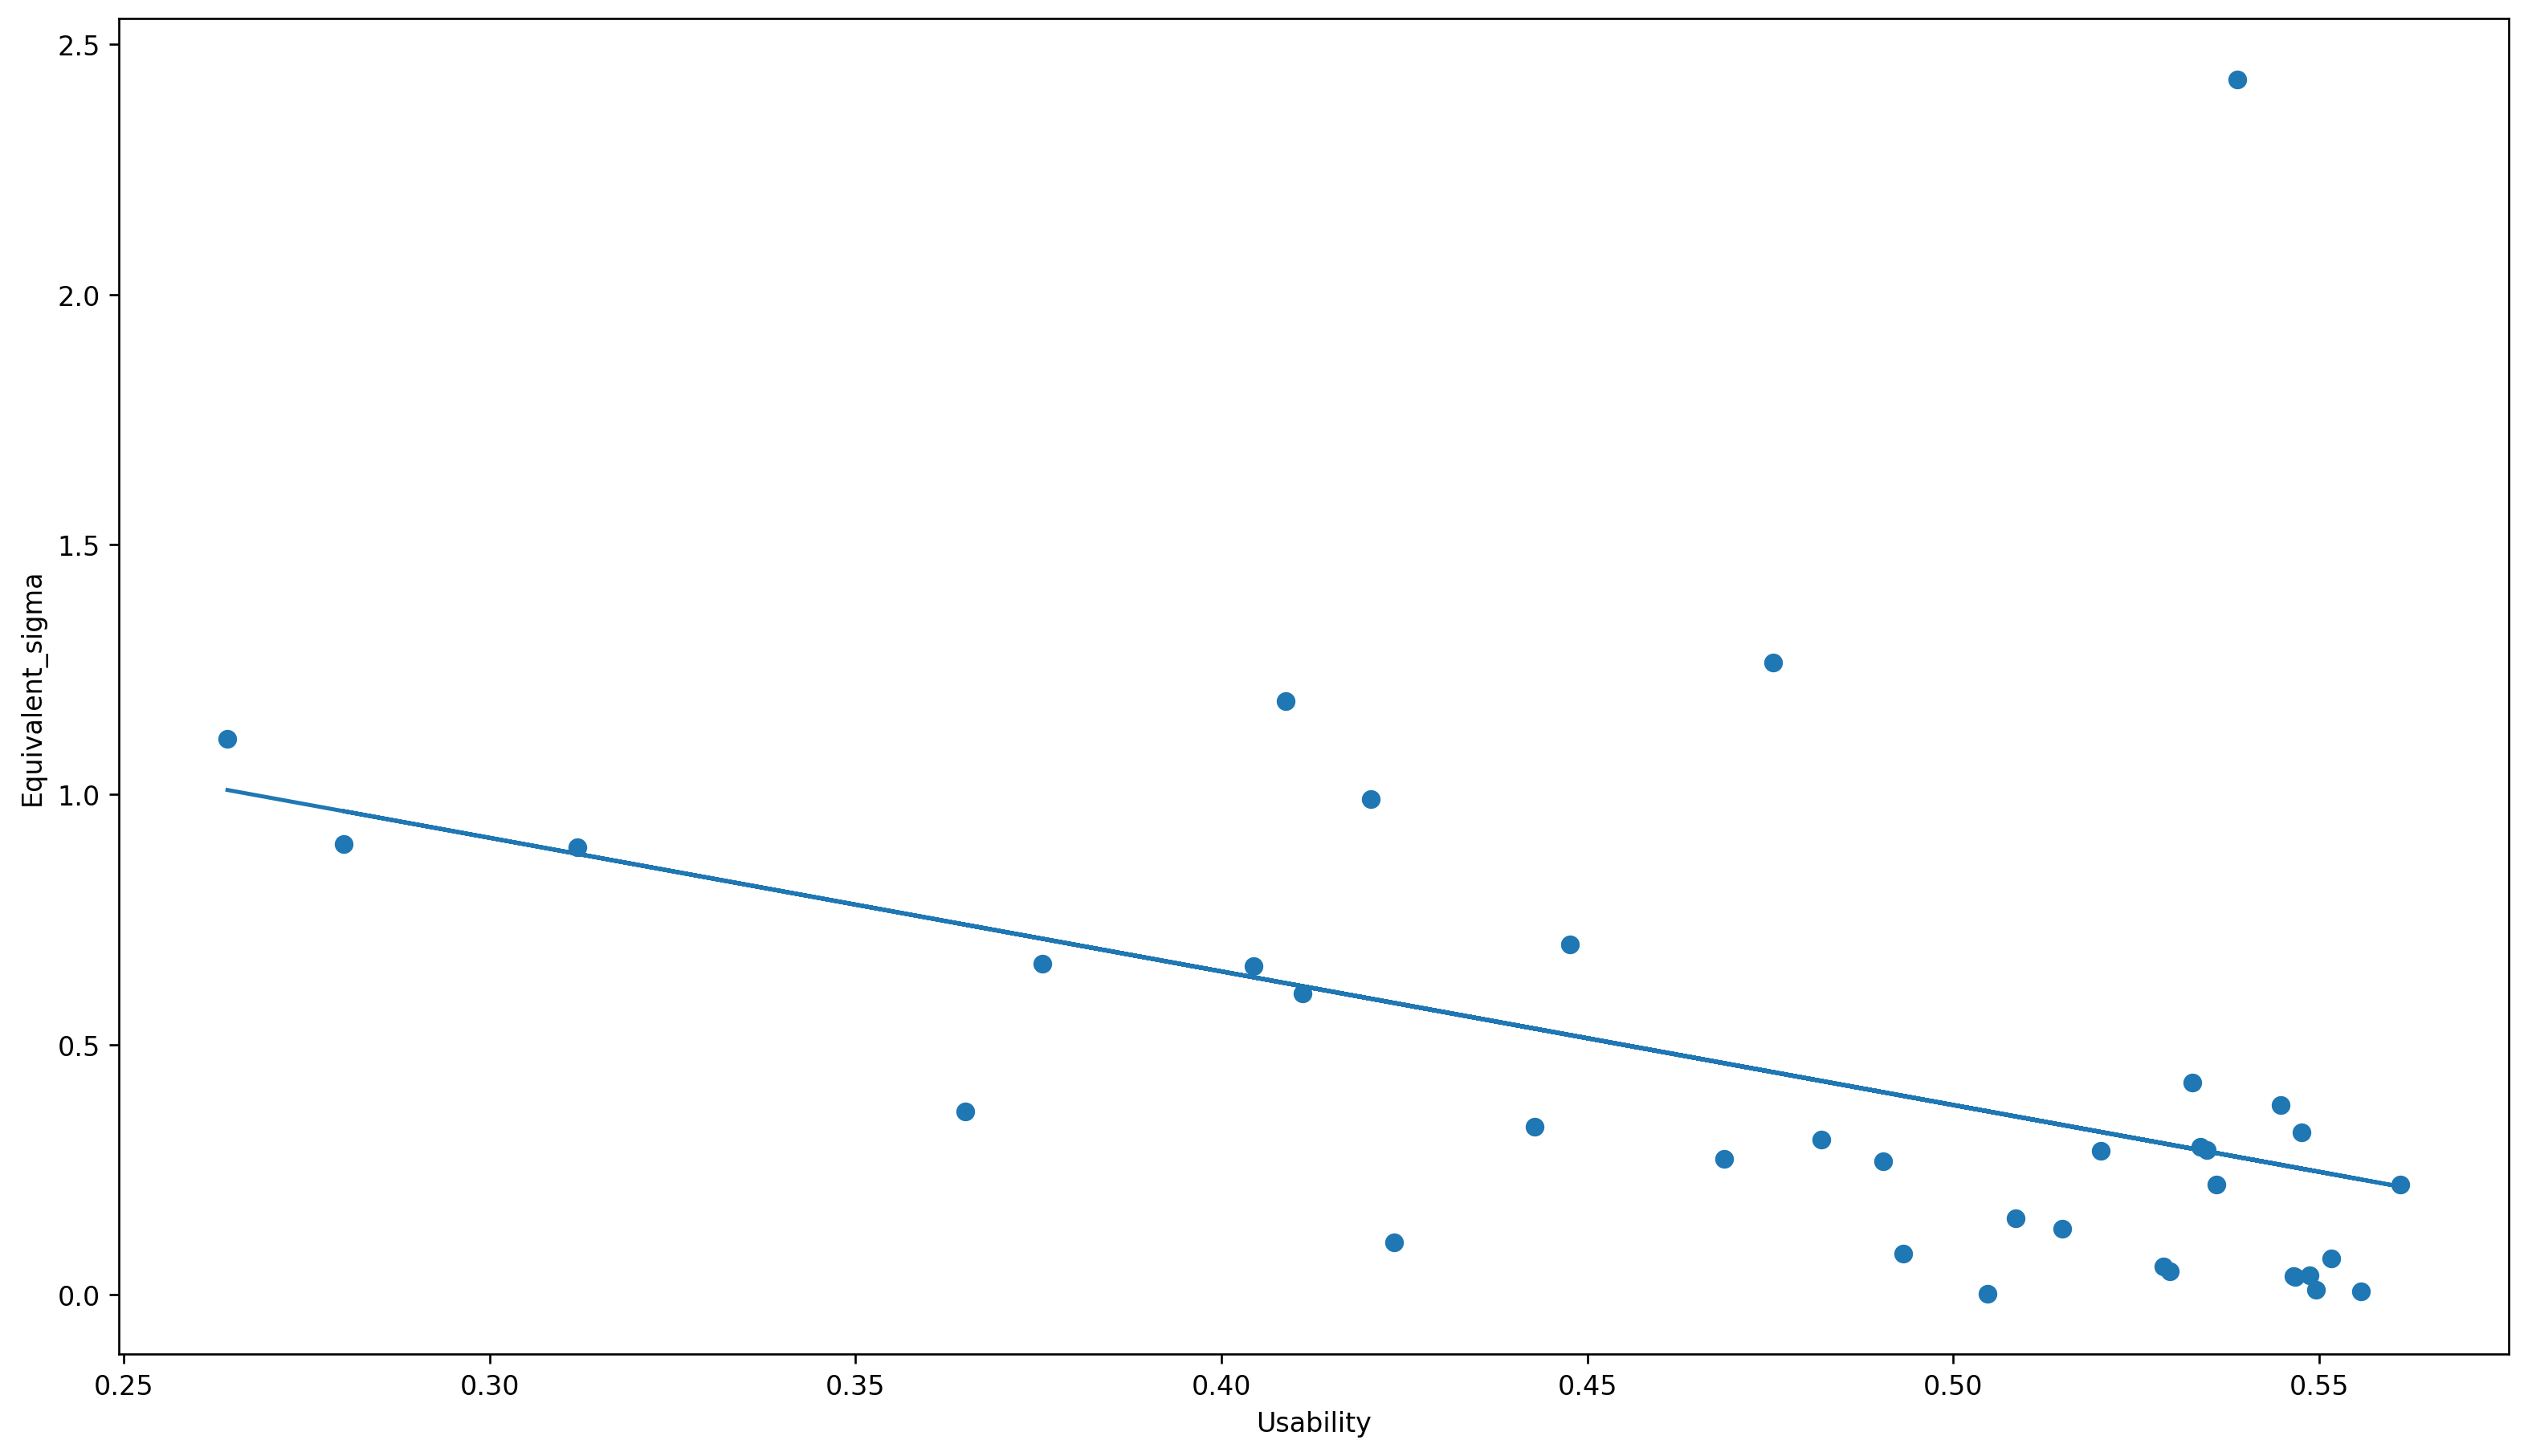

In [12]:
from matplotlib import pyplot as plt

x = np.array(list(file2usability.values()))
y = np.array(list(file2sigma.values()))

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
sigma_hat = p(x)

plt.figure(dpi=240,figsize=(16, 9))
plt.scatter(x, y)
plt.plot(file2usability.values(), sigma_hat)
plt.xlabel('Usability')
plt.ylabel('Equivalent_sigma')
plt.show()



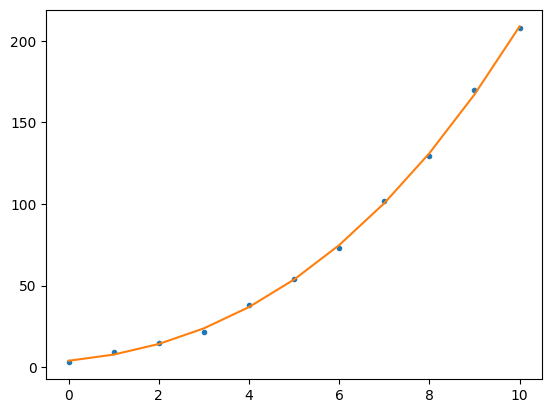

In [13]:
'''
Author: CloudSir
Date: 2021-08-01 13:40:50
LastEditTime: 2021-08-02 09:41:54
LastEditors: CloudSir
Description: Python拟合多项式
https://github.com/cloudsir
'''
import matplotlib.pyplot as plt
import numpy as np
 
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y = [2.83, 9.53, 14.52, 21.57, 38.26, 53.92, 73.15, 101.56, 129.54, 169.75, 207.59]
z1 = np.polyfit(x, y, 3) #用3次多项式拟合，输出系数从高到0
p1 = np.poly1d(z1) #使用次数合成多项式
y_pre = p1(x)
 
plt.plot(x,y,'.')
plt.plot(x,y_pre)
plt.show()


In [16]:
df = pd.read_excel(dir_name + f_name)
df

,voltage,current_cycle1,current_cycle2,current_cycle3,current_cycle4,current_cycle5,current_cycle6,current_cycle7,current_cycle8,current_cycle9,current_cycle10,current_cycle11,current_cycle12,current_cycle13,current_cycle14,current_cycle15,current_cycle16,current_cycle17,current_cycle18,current_cycle19
0,0.0,6.693900e-10,2.968590e-09,1.135050e-09,2.153680e-09,1.891750e-09,1.513400e-09,1.309670e-09,1.018630e-09,9.895300e-10,3.579770e-09,5.180480e-09,2.328300e-10,3.667080e-09,3.579770e-09,3.434250e-09,3.405150e-09,2.852180e-09,2.619300e-10,3.085010e-09
1,0.1,1.545413e-08,2.182787e-08,1.973240e-08,2.118759e-08,2.083834e-08,2.063462e-08,2.051820e-08,2.019806e-08,1.996523e-08,2.363231e-08,2.441811e-08,6.984900e-10,2.351590e-08,2.337038e-08,2.325396e-08,2.307934e-08,2.208981e-08,1.885928e-08,2.232264e-08
2,0.2,1.679291e-08,2.415618e-08,2.174056e-08,2.380693e-08,2.354500e-08,2.331217e-08,2.328306e-08,2.310844e-08,2.284651e-08,2.578599e-08,3.460445e-08,1.193260e-09,2.596062e-08,2.601882e-08,2.584420e-08,2.593151e-08,2.485467e-08,2.121669e-08,2.505840e-08
3,0.3,1.763692e-08,2.584420e-08,2.331217e-08,2.578599e-08,2.546585e-08,2.526212e-08,2.526212e-08,2.517481e-08,2.476736e-08,2.753222e-08,2.206070e-08,1.804440e-09,2.785237e-08,2.779416e-08,2.779416e-08,2.785237e-08,2.671732e-08,2.264278e-08,2.706656e-08
4,0.4,1.824810e-08,2.712477e-08,2.453453e-08,2.735760e-08,2.709567e-08,2.689194e-08,2.689194e-08,2.677552e-08,2.648449e-08,2.875458e-08,3.687455e-08,8.149100e-10,2.927845e-08,2.954039e-08,2.924935e-08,2.927845e-08,2.823072e-08,2.380693e-08,2.875458e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,-0.4,3.425521e-08,1.244276e-06,1.009001e-06,3.457535e-08,3.431342e-08,3.419700e-08,3.402238e-08,3.384775e-08,2.740318e-05,3.768946e-08,1.979060e-09,3.661262e-08,3.652531e-08,3.640889e-08,3.640889e-08,2.738499e-05,2.328306e-08,3.463356e-08,1.210978e-05
240,-0.3,3.442983e-08,9.419746e-07,5.791662e-07,3.477908e-08,3.460445e-08,3.442983e-08,3.413879e-08,3.408059e-08,2.739797e-05,3.067544e-08,1.673470e-08,3.690366e-08,3.681635e-08,3.675814e-08,3.669993e-08,2.738059e-05,2.392335e-08,3.533205e-08,9.139243e-06
241,-0.2,3.457535e-08,1.962180e-07,1.915905e-07,3.504101e-08,3.489549e-08,3.480818e-08,3.457535e-08,3.434252e-08,2.738551e-05,5.535549e-08,4.278260e-09,3.716559e-08,3.707828e-08,3.699097e-08,3.707828e-08,2.737273e-05,2.453453e-08,3.582682e-08,5.958893e-06
242,-0.1,3.477908e-08,1.836452e-08,5.529730e-09,3.527384e-08,3.501191e-08,3.504101e-08,3.501191e-08,3.451714e-08,2.072463e-05,4.700269e-08,2.083834e-08,3.748573e-08,3.736932e-08,3.742753e-08,3.742753e-08,2.734727e-05,2.517481e-08,3.643800e-08,3.208930e-06


In [44]:
def Kalman1D(observations, damping=0):
    # To return the smoothed time series data
    observation_covariance = damping
    initial_value_guess = observations[0]
    transition_matrix = 1
    transition_covariance = 0.1
    initial_value_guess
    kf = KalmanFilter(
            initial_state_mean=initial_value_guess,
            initial_state_covariance=observation_covariance,
            observation_covariance=observation_covariance,
            transition_covariance=transition_covariance,
            transition_matrices=transition_matrix
        )
    pred_state, state_cov = kf.smooth(observations)
    return pred_state



In [ ]:
def calculate_smoothed_cmean(f_name):
    eps = 1e-12

    current_cols = df.iloc[:, 1:]
    voltage_col = df.iloc[:, :1].values

    conductance_cols = current_cols.div(voltage_col + eps)
    conductance_mean_col = conductance_cols.mean(axis=1).values
    conductance_mean_col_head100 = conductance_mean_col[1: 101]
    c_mean_smooth = Kalman1D(conductance_mean_col_head100)
    c_mean_smooth = c_mean_smooth.T[0]
    return c_mean_smooth


In [73]:

eps = 1e-12

current_cols = df.iloc[:, 1:]
voltage_col = df.iloc[:, :1].values

conductance_cols = current_cols.div(voltage_col + eps)
conductance_mean_col = conductance_cols.mean(axis=1).values
conductance_mean_col_head100 = conductance_mean_col[1: 101]
c_mean_smooth = Kalman1D(conductance_mean_col_head100)
c_mean_smooth = c_mean_smooth.T[0]

In [96]:
LCIS(c_mean_smooth)

(67, 99)

In [75]:

whether_increase = (c_mean_smooth - np.roll(c_mean_smooth, 1))[1: ] > 0
whether_increase

array([False, False, False, False, False, False,  True, False, False,
       False, False, False,  True,  True, False, False, False,  True,
        True, False, False, False, False,  True, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True, False, False,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True, False, False,
       False, False,  True, False,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [95]:

# st_indx = 0
# end_indx = 0
# longest_st = 0
# longest_end = 0
# longest_len = 0
# cum_inc_len = 0
# decrease_cnt = 0


# for st_indx, item in enumerate(whether_increase):
#     end_indx = st_indx
#     if item == True:
#         end_indx += 1
#         cum_inc_len += 1
        
#     else:
#         decrease_cnt += 1

#     if decrease_cnt == 2:
#         '''more than 2 times decrease: reset'''

#         # longest_len = cum_inc_len if cum_inc_len > longest_len else longest_len
#         if cum_inc_len > longest_len:
#             longest_len = cum_inc_len
#             longest_st = st_indx
#             longest_end = end_indx 
#         cum_inc_len = 0
#         # st_indx = i
#         # end_indx = i + 1
        
# longest_st, longest_end, cum_inc_len

(0, 0, 63)

(0, 0)

In [51]:
c_mean_smooth - c_mean_smooth

array([[2.02945611e-07],
       [1.15542203e-07],
       [8.02857228e-08],
       [6.52615092e-08],
       [5.45834674e-08],
       [4.75464675e-08],
       [4.31677632e-08],
       [4.66178263e-08],
       [3.77277550e-08],
       [3.35934795e-08],
       [3.29318885e-08],
       [2.93259382e-08],
       [2.71973534e-08],
       [3.88157572e-07],
       [3.92556397e-07],
       [3.52551674e-07],
       [2.95907562e-07],
       [2.76185140e-07],
       [3.09926776e-07],
       [3.60866803e-07],
       [3.33800543e-07],
       [2.77936711e-07],
       [2.37916803e-07],
       [2.10232400e-07],
       [7.22101479e-07],
       [6.96727929e-07],
       [6.67150475e-07],
       [6.35660986e-07],
       [6.23194959e-07],
       [5.87520991e-07],
       [5.79996387e-07],
       [5.74645981e-07],
       [5.90796592e-07],
       [7.76085220e-07],
       [9.99794498e-07],
       [1.09045889e-06],
       [1.21794685e-06],
       [1.24722694e-06],
       [1.20529256e-06],
       [1.19817479e-06],


In [52]:
def LCIS(arr):
    """
    求最长连续[递增]*子序列
    返回最长连续递增子序列的
    ---------
    *该[递增]序列并不要求始终严格增，而是最多允许两次递减
    """
    decrease_cnt = 0
    start_index = 0
    end_index = 0
    sub_len = 0
    longest_start = 0
    longest_end = 0
    longest_len = 0
    decrease_point_0 = -1
    decrease_point_1 = -1
    for i in range(1, len(arr)):
        if arr[i] > arr[i-1]:
            end_index += 1
        else:
            decrease_cnt += 1
            if decrease_cnt == 1:
                end_index += 1
                decrease_point_0 = end_index
            elif decrease_cnt == 2:
                end_index += 1
                decrease_point_1 = end_index
            else:
                sub_len = end_index - start_index + 1
                if longest_len < sub_len:
                    longest_len = sub_len
                    longest_start = start_index
                    longest_end = end_index
                start_index = decrease_point_0
                decrease_point_0 = decrease_point_1
                decrease_point_1 = i
                end_index = i
                decrease_cnt = 2

    sub_len = end_index - start_index + 1
    if longest_len < sub_len:
        longest_len = sub_len
        longest_start = start_index
        longest_end = end_index

    return longest_start, longest_end


(0, 0)